# How consistently are areas ranked?

For each month, compute the ranking of each area in terms of ASB incidents (with smoothing) and measure temporal consistency (somehow)


In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import (
    CATEGORIES,
    calc_gini,
    extract_crime_data,
    get_census_boundaries,
    get_force_boundary,
    get_geog_lookup,
    get_hex_grid,
    get_square_grid,
    lorenz_curve,
    spearman_rank_correlation_matrix,
    tokenize_force_name,
)

## Set parameters and fetch crime data

In [85]:
FORCE = "West Yorkshire"
OBSERVATION_WINDOW = 3  # months
AREA: Literal["MSOA", "LSOA", "OA", "GRID", "HEX", "STREET"] = "HEX"
SAMPLE_FRACTION = 0.5

force_boundary = get_force_boundary(FORCE)

CATEGORY = CATEGORIES[1]
raw_crime_data = extract_crime_data(tokenize_force_name(FORCE))
# filter by catgegory and remove any points
raw_crime_data = raw_crime_data[raw_crime_data["Crime type"] == CATEGORY]
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
raw_crime_data

Month            Reported by           Falls within  \
Crime ID                                                          
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
NaN       2022-05  West Yorkshire Police  West Yorkshire Police   
...           ...                    ...                    ...   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   
NaN       2025-04  West Yorkshire Police  West Yorkshire Police   

                              Location  LSOA code       LSOA name  \
Crime ID                                                            
NaN         On or near Queen'S Gardens  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN              On or near Wells Road  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN            On or near Springs Lane  E01010691   Bradford 002A   
...                                ...        ...             ...   
NaN             On or near John Street  E01011863  Wakefield 044D   
NaN            On or near Beech Street  E01011863  Wakefield 044D   
NaN         On or near Princess Avenue  E01011863  Wakefield 044D   
NaN                On or near Beamshaw  E01011866  Wakefield 045B   
NaN         On or near Park/Open Space  E01011868  Wakefield 045C   

                     Crime type Last outcome category  Context  \
Crime ID                                                         
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
...                         ...                   ...      ...   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   

                               geometry  
Crime ID                                 
NaN       POINT (411354.013 447133.948)  
NaN       POINT (411854.969 447613.948)  
NaN        POINT (411758.03 447302.948)  
NaN       POINT (411854.969 447613.948)  
NaN       POINT (412391.978 447481.039)  
...                                 ...  
NaN       POINT (446750.007 410878.044)  
NaN       POINT (446414.024 410431.008)  
NaN       POINT (446666.975 410800.005)  
NaN        POINT (444840.023 410291.97)  
NaN       POINT (444982.991 411990.995)  

[81698 rows x 10 columns]

## Get spatial data

Aggregrate crime to spatial units requested

In [86]:
# TODO for non-LSOA areas ensure we have full coverage in the force area
boundaries = get_census_boundaries("LSOA21", "GC", overlapping=force_boundary)
# TODO is this next line needed?
crime_data = raw_crime_data[raw_crime_data["LSOA code"].isin(boundaries.index)]  # ["LSOA21CD"])]
match AREA:
    case "LSOA":
        crime_data.loc[:, "area"] = crime_data["LSOA code"]
        # boundaries already set
    case "MSOA":
        mapping = get_geog_lookup("lsoa21cd", ["msoa21cd"])
        crime_data["area"] = crime_data["LSOA code"].map(mapping.msoa21cd.to_dict())
        boundaries = get_census_boundaries("MSOA21", "GC", overlapping=force_boundary)
    case "OA":
        # do a spatial join to get ALL OAs in force area
        boundaries = (
            get_census_boundaries("OA21", "GC").sjoin(force_boundary[["geometry"]]).drop(columns=["index_right"])
        )
        # get crime counts for OAs by right-joining boundaries to crime data (this wont include crime-free OAs)
        crime_data = boundaries.sjoin(crime_data, how="right").rename(columns={"OA21CD": "area"})
        # # restore the crime-free OAs by left joining on the full set
        # oa_boundaries = oa_boundaries.join(asb_by_oa, how="left").fillna(0)
    case "GRID":
        # get the grid cells in the force area
        boundaries = get_square_grid(500.0, FORCE)
        crime_data = boundaries.sjoin(crime_data, how="right").rename(columns={"index_left": "area"})
    case "HEX":
        boundaries = get_hex_grid(8, FORCE)
        crime_data = boundaries.sjoin(crime_data, how="right").rename(columns={"h3_polyfill": "area"})

crime_data

area    PFA23CD         PFA23NM    Month  \
Crime ID                                                        
NaN       881942cab1fffff  E23000010  West Yorkshire  2022-05   
NaN       881942cab9fffff  E23000010  West Yorkshire  2022-05   
NaN       881942cab9fffff  E23000010  West Yorkshire  2022-05   
NaN       881942cab9fffff  E23000010  West Yorkshire  2022-05   
NaN       881942cab9fffff  E23000010  West Yorkshire  2022-05   
...                   ...        ...             ...      ...   
NaN       8819421531fffff  E23000010  West Yorkshire  2025-04   
NaN       8819421533fffff  E23000010  West Yorkshire  2025-04   
NaN       8819421531fffff  E23000010  West Yorkshire  2025-04   
NaN       88194202cbfffff  E23000010  West Yorkshire  2025-04   
NaN       8819421523fffff  E23000010  West Yorkshire  2025-04   

                    Reported by           Falls within  \
Crime ID                                                 
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
...                         ...                    ...   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   
NaN       West Yorkshire Police  West Yorkshire Police   

                              Location  LSOA code       LSOA name  \
Crime ID                                                            
NaN         On or near Queen'S Gardens  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN              On or near Wells Road  E01010692   Bradford 001D   
NaN       On or near Bus/Coach Station  E01010692   Bradford 001D   
NaN            On or near Springs Lane  E01010691   Bradford 002A   
...                                ...        ...             ...   
NaN             On or near John Street  E01011863  Wakefield 044D   
NaN            On or near Beech Street  E01011863  Wakefield 044D   
NaN         On or near Princess Avenue  E01011863  Wakefield 044D   
NaN                On or near Beamshaw  E01011866  Wakefield 045B   
NaN         On or near Park/Open Space  E01011868  Wakefield 045C   

                     Crime type Last outcome category  Context  \
Crime ID                                                         
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
...                         ...                   ...      ...   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   
NaN       Anti-social behaviour                   NaN      NaN   

                               geometry  
Crime ID                                 
NaN       POINT (411354.013 447133.948)  
NaN       POINT (411854.969 447613.948)  
NaN        POINT (411758.03 447302.948)  
NaN       POINT (411854.969 447613.948)  
NaN       POINT (412391.978 447481.039)  
...                                 ...  
NaN       POINT (446750.007 410878.044)  
NaN       POINT (446414.024 410431.008)  
NaN       POINT (446666.975 410800.005)  
NaN        POINT (444840.023 410291.97)  
NaN       POINT (444982.991 411990.995)  

[80677 rows x 13 columns]

## Show total counts for each area on a map

(too many street segments to render)

In [88]:
if AREA == "STREET":
    map = None
else:
    total_counts = crime_data.groupby("area").size().rename("total_counts")
    map = (
        boundaries.join(total_counts)
        .fillna(0)
        .explore(
            "total_counts",
            cmap="Reds",
            tiles="CartoDB positron",
            style_kwds=dict(color="black", weight=0.5, opacity=0.2, fillOpacity=0.7),
        )
    )
map

In [90]:
# ensure we account for crime-free LSOAs in the data
counts = crime_data.groupby(["Month", "area"])["Crime type"].count().unstack(level="Month", fill_value=0).sort_index()
# counts = counts.reindex(lsoa_boundaries.index, fill_value=0)
num_areas = len(crime_data.area.unique())
smoothed_counts = counts.T.rolling(OBSERVATION_WINDOW).mean().dropna().T
smoothed_counts

Month             2022-07   2022-08   2022-09   2022-10  2022-11   2022-12  \
area                                                                         
881942004bfffff  1.000000  1.000000  0.333333  0.333333      0.0  0.000000   
881942004dfffff  0.000000  0.000000  0.000000  0.000000      0.0  0.000000   
8819420061fffff  0.000000  0.000000  0.000000  0.000000      0.0  0.333333   
8819420065fffff  0.000000  0.000000  0.000000  0.000000      0.0  0.000000   
881942006dfffff  0.000000  0.000000  0.000000  0.000000      0.0  0.000000   
...                   ...       ...       ...       ...      ...       ...   
881942d4cbfffff  0.000000  0.000000  0.000000  0.000000      0.0  0.000000   
881942d4d3fffff  0.000000  0.000000  0.000000  0.000000      0.0  0.000000   
881942d4d5fffff  0.333333  0.666667  0.666667  0.333333      0.0  0.000000   
881942d4d9fffff  0.000000  0.000000  0.000000  0.000000      0.0  0.000000   
881942d4ebfffff  0.000000  0.000000  0.000000  0.000000      0.0  0.000000   

Month             2023-01   2023-02   2023-03   2023-04  ...   2024-07  \
area                                                     ...             
881942004bfffff  0.000000  0.000000  0.000000  0.333333  ...  0.333333   
881942004dfffff  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
8819420061fffff  0.333333  0.333333  0.000000  0.000000  ...  0.000000   
8819420065fffff  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
881942006dfffff  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
...                   ...       ...       ...       ...  ...       ...   
881942d4cbfffff  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
881942d4d3fffff  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
881942d4d5fffff  0.000000  0.000000  0.666667  0.666667  ...  0.666667   
881942d4d9fffff  0.000000  0.000000  0.666667  1.000000  ...  0.000000   
881942d4ebfffff  0.000000  0.000000  0.333333  0.333333  ...  0.000000   

Month             2024-08   2024-09   2024-10   2024-11   2024-12   2025-01  \
area                                                                          
881942004bfffff  0.000000  0.000000  0.000000  0.333333  0.333333  0.333333   
881942004dfffff  0.333333  0.333333  0.333333  0.000000  0.000000  0.000000   
8819420061fffff  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8819420065fffff  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
881942006dfffff  0.333333  1.000000  1.000000  0.666667  0.000000  0.000000   
...                   ...       ...       ...       ...       ...       ...   
881942d4cbfffff  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
881942d4d3fffff  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
881942d4d5fffff  0.666667  0.666667  0.000000  0.000000  0.000000  0.000000   
881942d4d9fffff  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
881942d4ebfffff  0.000000  0.000000  0.333333  0.333333  0.333333  0.000000   

Month             2025-02   2025-03   2025-04  
area                                           
881942004bfffff  0.333333  0.333333  1.000000  
881942004dfffff  0.000000  0.000000  0.000000  
8819420061fffff  0.000000  0.000000  0.333333  
8819420065fffff  0.000000  0.000000  0.000000  
881942006dfffff  0.000000  0.000000  0.000000  
...                   ...       ...       ...  
881942d4cbfffff  0.000000  0.333333  0.666667  
881942d4d3fffff  0.000000  0.000000  0.000000  
881942d4d5fffff  0.000000  0.000000  0.000000  
881942d4d9fffff  0.000000  0.000000  0.000000  
881942d4ebfffff  0.000000  0.000000  0.000000  

[1850 rows x 34 columns]

Month     2022-05   2022-06   2022-07   2022-08   2022-09   2022-10   2022-11  \
Month                                                                           
2022-05  1.000000  0.919364  0.888848  0.895438  0.915979  0.914769  0.914261   
2022-06  0.919364  1.000000  0.896503  0.901740  0.906250  0.905805  0.894082   
2022-07  0.888848  0.896503  1.000000  0.901419  0.898034  0.888388  0.869630   
2022-08  0.895438  0.901740  0.901419  1.000000  0.904208  0.893868  0.879687   
2022-09  0.915979  0.906250  0.898034  0.904208  1.000000  0.922091  0.911063   
2022-10  0.914769  0.905805  0.888388  0.893868  0.922091  1.000000  0.923823   
2022-11  0.914261  0.894082  0.869630  0.879687  0.911063  0.923823  1.000000   
2022-12  0.884179  0.855006  0.820562  0.831021  0.882425  0.893732  0.925155   
2023-01  0.902357  0.877846  0.854424  0.861391  0.898236  0.910811  0.925012   
2023-02  0.910055  0.895183  0.869130  0.874591  0.911051  0.918747  0.925763   
2023-03  0.909000  0.894527  0.876277  0.885321  0.911346  0.917510  0.915331   
2023-04  0.896118  0.892413  0.883640  0.893068  0.904511  0.901955  0.893591   
2023-05  0.895058  0.893286  0.887704  0.896240  0.896466  0.893291  0.879543   
2023-06  0.890778  0.895000  0.885558  0.895514  0.900005  0.896763  0.890031   
2023-07  0.899969  0.895085  0.885142  0.894164  0.901079  0.900837  0.897320   
2023-08  0.904062  0.899659  0.888001  0.891919  0.909277  0.901391  0.893537   
2023-09  0.901489  0.898077  0.886052  0.899276  0.904318  0.901493  0.889981   
2023-10  0.905083  0.895479  0.882518  0.891861  0.907482  0.911212  0.900998   
2023-11  0.906069  0.897711  0.873652  0.883934  0.907384  0.916967  0.921565   
2023-12  0.892780  0.866253  0.831124  0.841253  0.888452  0.900763  0.923926   
2024-01  0.898647  0.879974  0.850445  0.858668  0.898937  0.904637  0.916345   
2024-02  0.904258  0.885143  0.863709  0.874865  0.899792  0.911600  0.910800   
2024-03  0.889415  0.882643  0.869274  0.877755  0.897238  0.901772  0.902678   
2024-04  0.892125  0.888106  0.872416  0.885369  0.899256  0.897642  0.896359   
2024-05  0.876024  0.873914  0.871327  0.875347  0.883604  0.882548  0.867280   
2024-06  0.879452  0.879722  0.882703  0.884500  0.888655  0.881625  0.869542   
2024-07  0.882047  0.884678  0.879598  0.884785  0.887747  0.887667  0.873400   
2024-08  0.885869  0.884235  0.885977  0.891256  0.892634  0.890261  0.878688   
2024-09  0.903608  0.893158  0.877654  0.891110  0.904777  0.908337  0.908948   
2024-10  0.891067  0.887566  0.881294  0.888478  0.895957  0.902623  0.893548   
2024-11  0.905220  0.888317  0.880742  0.891217  0.902187  0.906065  0.906223   
2024-12  0.893247  0.872124  0.849784  0.856201  0.893412  0.898858  0.915677   
2025-01  0.897500  0.873591  0.851418  0.850212  0.893565  0.902222  0.919634   
2025-02  0.896105  0.871094  0.843007  0.848509  0.893826  0.900152  0.922376   
2025-03  0.890628  0.882071  0.873480  0.883314  0.901177  0.898077  0.892141   
2025-04  0.861016  0.861373  0.856182  0.860172  0.862975  0.859805  0.843969   

Month     2022-12   2023-01   2023-02  ...   2024-07   2024-08   2024-09  \
Month                                  ...                                 
2022-05  0.884179  0.902357  0.910055  ...  0.882047  0.885869  0.903608   
2022-06  0.855006  0.877846  0.895183  ...  0.884678  0.884235  0.893158   
2022-07  0.820562  0.854424  0.869130  ...  0.879598  0.885977  0.877654   
2022-08  0.831021  0.861391  0.874591  ...  0.884785  0.891256  0.891110   
2022-09  0.882425  0.898236  0.911051  ...  0.887747  0.892634  0.904777   
2022-10  0.893732  0.910811  0.918747  ...  0.887667  0.890261  0.908337   
2022-11  0.925155  0.925012  0.925763  ...  0.873400  0.878688  0.908948   
2022-12  1.000000  0.932486  0.922756  ...  0.826562  0.832795  0.882256   
2023-01  0.932486  1.000000  0.929843  ...  0.855093  0.858580  0.899705   
2023-02  0.922756  0.929843  1.000000  ...  0.867689  0.869318  0.904258   
2023-03  

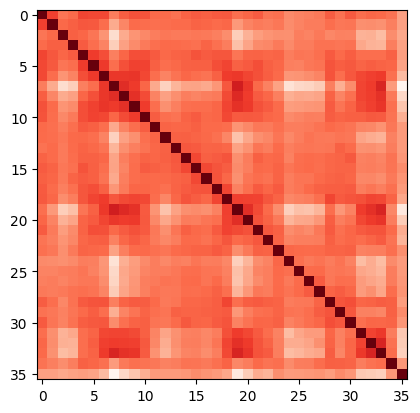

In [95]:
n = len(counts.columns)
correlations = spearman_rank_correlation_matrix(counts)
cdf = pd.DataFrame(index=counts.columns, data=correlations, columns=counts.columns)
plt.imshow(cdf, cmap="Reds")
cdf

Month            2022-07  2022-08  2022-09  2022-10  2022-11  2022-12  \
area                                                                    
881942c5d7fffff      1.0      1.0      1.0      1.0      1.0      1.0   
881942cce5fffff      4.0      4.0      2.0      2.0      2.0      2.0   
8819421a95fffff    507.0    423.0    418.0    510.0    626.0    281.0   
881942566dfffff      3.0      3.0      3.0      6.0      8.0     12.0   
8819421b11fffff     55.0     33.0     61.0     39.0     38.0     24.0   
...                  ...      ...      ...      ...      ...      ...   
881942d4d3fffff   1195.0   1226.0   1203.0   1158.0   1089.0   1030.0   
881942d4d5fffff    869.0    751.0    740.0    860.0   1089.0   1030.0   
881942d4d9fffff   1195.0   1226.0   1203.0   1158.0   1089.0   1030.0   
881942d4ebfffff   1195.0   1226.0   1203.0   1158.0   1089.0   1030.0   
881942004dfffff   1195.0   1226.0   1203.0   1158.0   1089.0   1030.0   

Month            2023-01  2023-02  2023-03  2023-04  ...  2024-07  2024-08  \
area                                                 ...                     
881942c5d7fffff      1.0      1.0      1.0      1.0  ...      1.0      1.0   
881942cce5fffff      2.0      2.0      2.0      2.0  ...      3.0      4.0   
8819421a95fffff    231.0    282.0    734.0    793.0  ...      5.0      7.0   
881942566dfffff     33.0      7.0     11.0      3.0  ...     42.0     57.0   
8819421b11fffff     19.0      7.0     20.0     56.0  ...    185.0    113.0   
...                  ...      ...      ...      ...  ...      ...      ...   
881942d4d3fffff    983.0    971.0   1033.0   1103.0  ...   1247.0   1214.0   
881942d4d5fffff    983.0    971.0    565.0    643.0  ...    791.0    785.0   
881942d4d9fffff    983.0    971.0    565.0    530.0  ...   1247.0   1214.0   
881942d4ebfffff    983.0    971.0    734.0    793.0  ...   1247.0   1214.0   
881942004dfffff    983.0    971.0   1033.0   1103.0  ...   1247.0    935.0   

Month            2024-09  2024-10  2024-11  2024-12  2025-01  2025-02  \
area                                                                    
881942c5d7fffff      1.0      1.0      1.0      1.0      1.0      1.0   
881942cce5fffff      3.0      3.0      3.0      3.0      2.0      2.0   
8819421a95fffff      6.0      8.0     19.0     12.0      7.0      5.0   
881942566dfffff     98.0     62.0     13.0      8.0      7.0     18.0   
8819421b11fffff     56.0     24.0     26.0     31.0     50.0     26.0   
...                  ...      ...      ...      ...      ...      ...   
881942d4d3fffff   1176.0   1158.0   1145.0   1139.0   1099.0   1025.0   
881942d4d5fffff    754.0   1158.0   1145.0   1139.0   1099.0   1025.0   
881942d4d9fffff   1176.0   1158.0   1145.0   1139.0   1099.0   1025.0   
881942d4ebfffff   1176.0    891.0    848.0    823.0   1099.0   1025.0   
881942004dfffff    909.0    891.0   1145.0   1139.0   1099.0   1025.0   

Month            2025-03  2025-04  
area                               
881942c5d7fffff      1.0      1.0  
881942cce5fffff      2.0      2.0  
8819421a95fffff      4.0      3.0  
881942566dfffff     10.0      3.0  
8819421b11fffff     13.0      5.0  
...                  ...      ...  
881942d4d3fffff   1066.0   1185.0  
881942d4d5fffff   1066.0   1185.0  
881942d4d9fffff   1066.0   1185.0  
881942d4ebfffff   1066.0   1185.0  
881942004dfffff   1066.0   1185.0  

[1850 rows x 34 columns]

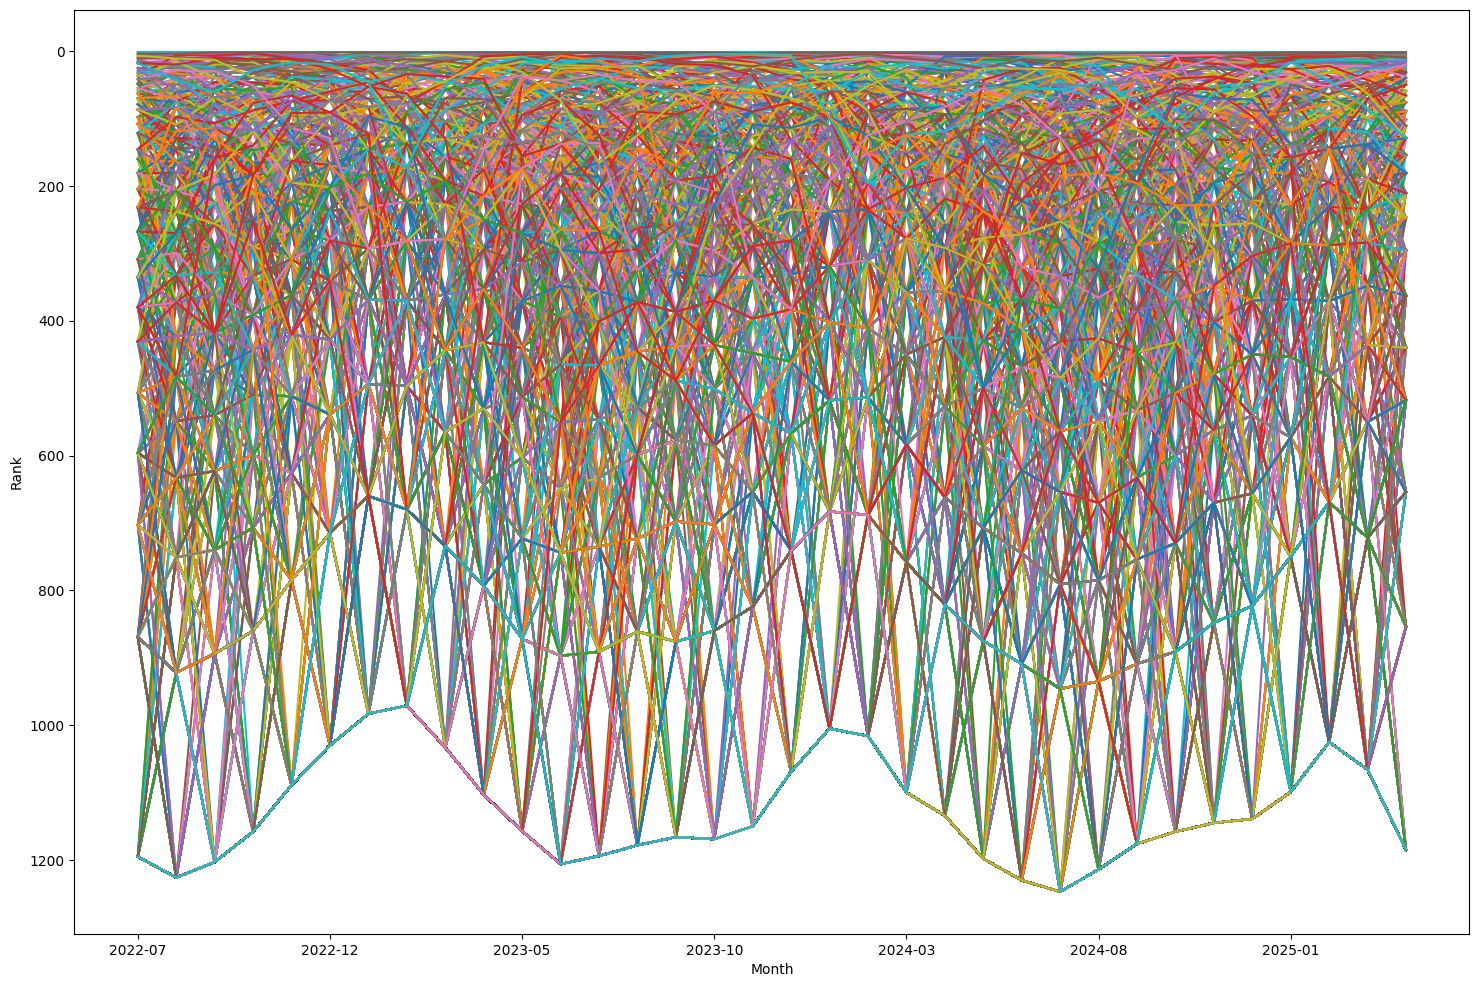

In [93]:
ranks = smoothed_counts.apply(lambda col: col.rank(method="min", ascending=False))

ax = ranks.T.plot(figsize=(18, 12), xlabel="Month", ylabel="Rank", legend=False)
ax.invert_yaxis()

ranks.sort_values(by=ranks.columns[-1])

# hmmm. Jackson Pollocks

In [102]:
fl = lorenz_curve(smoothed_counts.iloc[:, 0])
len(fl[fl >= 0.5].index)

175

In [ ]:
def stats(counts: pd.Series):
    total_areas = len(counts)
    full_lorenz = lorenz_curve(counts)
    gini, lorenz = calc_gini(counts)  # .sort_values().cumsum() / counts.sum()
    return pd.Series(
        data={
            "prop_zero": (counts == 0).mean(),
            "prop_threshold": (full_lorenz >= SAMPLE_FRACTION).sum() / total_areas,
            "gini": gini,
            "lorenz": lorenz.to_numpy(),
            # TODO list top x areas?
        },
        name=counts.name,
    )


stats = pd.concat([stats(series) for _, series in smoothed_counts.items()], axis=1).T
stats

prop_zero prop_threshold      gini  \
2022-07  0.354595       0.094595  0.714946   
2022-08  0.337838       0.097838  0.707366   
2022-09   0.35027       0.096757  0.711349   
2022-10  0.374595       0.092973   0.71841   
2022-11  0.411892       0.084865  0.735652   
2022-12  0.443784           0.08  0.745405   
2023-01  0.469189       0.081622  0.745013   
2023-02  0.475676       0.085405  0.739678   
2023-03  0.442162       0.090811  0.728217   
2023-04  0.404324       0.095676  0.716971   
2023-05  0.375135       0.098919  0.706886   
2023-06  0.348649       0.097838  0.705708   
2023-07  0.355135       0.095676  0.711155   
2023-08  0.363784       0.094054  0.716291   
2023-09   0.37027       0.094054  0.716846   
2023-10  0.368649       0.093514  0.718837   
2023-11  0.378919       0.089189  0.725464   
2023-12  0.422703       0.083243   0.74161   
2024-01  0.457297       0.084865  0.738078   
2024-02  0.451351       0.088108  0.732424   
2024-03  0.405946       0.091351  0.717685   
2024-04  0.387568       0.095135  0.711736   
2024-05  0.352973       0.097838   0.70564   
2024-06  0.335676       0.101622  0.699578   
2024-07  0.326486       0.101622  0.695653   
2024-08  0.344324       0.102703  0.697588   
2024-09  0.364865       0.100541   0.70163   
2024-10  0.374595       0.098919  0.708493   
2024-11  0.381622       0.093514  0.717799   
2024-12  0.384865       0.090811  0.718754   
2025-01  0.406486       0.082703  0.729971   
2025-02  0.446486       0.076757  0.746587   
2025-03  0.424324       0.082703  0.736821   
2025-04      0.36       0.096216  0.702918   

                                                    lorenz  
2022-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2022-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-06  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2023-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-06  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2024-12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2025-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

Text(0.5, 1.0, 'Lorenz curves')

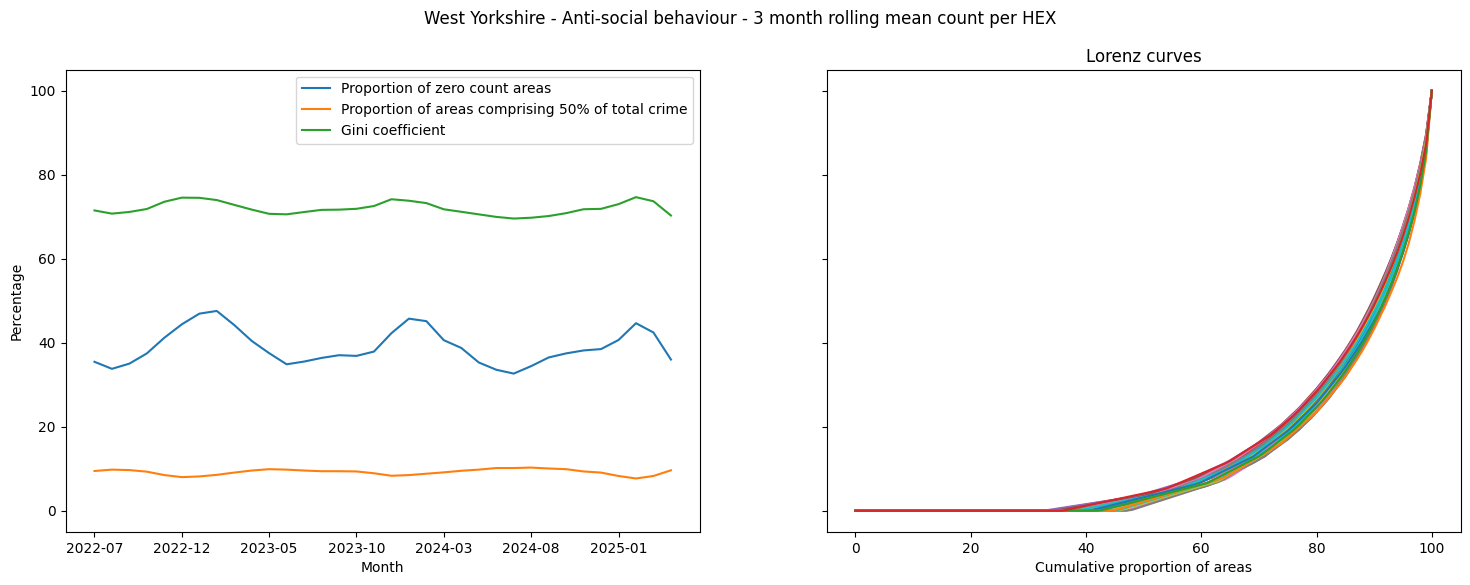

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.suptitle(f"{FORCE} - {CATEGORY} - {OBSERVATION_WINDOW} month rolling mean count per {AREA}")

(stats.prop_zero * 100).plot(ax=axs[0], label="Proportion of zero count areas")
(stats.prop_threshold * 100).plot(
    ax=axs[0], label=f"Proportion of areas comprising {SAMPLE_FRACTION:.0%} of total crime"
)
(stats.gini * 100).plot(ax=axs[0], label="Gini coefficient")
axs[0].set_xlabel("Month")
axs[0].set_ylabel("Percentage")
axs[0].legend()

for name, row in stats.iterrows():
    axs[1].plot(range(101), row["lorenz"] * 100, label=f"{name}")
axs[1].set_xlabel("Cumulative proportion of areas")
axs[1].set_ylabel("Cumulative proportion of crime")
axs[1].set_title("Lorenz curves")